In [1]:
%load_ext lab_black
%load_ext autotime
import pandas as pd
import numpy as np

time: 253 ms (started: 2022-09-17 17:55:47 -07:00)


The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32 x 32 color images evenly divided across 10 classes (e.g. airplane, cat, truck, bird). This dataset does not embed very well with any dimensionality reduction method I am aware of, but the activation layers of a convolutional neural network trained with it was visualized via [Barnes-Hut t-SNE](http://jmlr.org/papers/v15/vandermaaten14a.html).

## Load the data

In [2]:
import pickle
import tarfile
from io import BytesIO

import requests

n_images = 60000
nx = 32
ny = 32
n_channels = 3
n_features = nx * ny * n_channels
n_batches = 5
n_images_per_batch = 10000

data = np.empty((n_images, n_features), dtype=np.uint8)
labels = np.empty((n_images,), dtype=np.uint8)

url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
req = requests.get(url, timeout=10)
with tarfile.open(fileobj=BytesIO(req.content), mode="r") as tar_obj:
    # training batches
    for i in range(n_batches):
        batch_id = i + 1
        batch_pkl = tar_obj.extractfile(f"cifar-10-batches-py/data_batch_{batch_id}")
        batch = pickle.load(batch_pkl, encoding="bytes")
        data[(i * n_images_per_batch) : (i + 1) * n_images_per_batch] = batch[b"data"]
        labels[(i * n_images_per_batch) : (i + 1) * n_images_per_batch] = batch[
            b"labels"
        ]

    # test batch
    batch_pkl = tar_obj.extractfile(f"cifar-10-batches-py/test_batch")
    batch = pickle.load(batch_pkl, encoding="bytes")
    data[50000:] = batch[b"data"]
    labels[50000:] = batch[b"labels"]

    # label names
    batches_meta = pickle.load(
        tar_obj.extractfile(f"cifar-10-batches-py/batches.meta"), encoding="bytes"
    )
    label_names = np.array([x.decode("UTF-8") for x in batches_meta[b"label_names"]])

data.shape, labels.shape, label_names

((60000, 3072),
 (60000,),
 array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
        'horse', 'ship', 'truck'], dtype='<U10'))

time: 10.3 s (started: 2022-09-17 17:55:48 -07:00)


## View image

Converting the images back into a form that `matplotlib` can handle requires some contortions. See [this stack overflow question](https://stackoverflow.com/q/35995999/4096483) for many, many suggestions on how to go about this and [this binary study blogpost](https://www.binarystudy.com/2021/09/how-to-load-preprocess-visualize-CIFAR-10-and-CIFAR-100.html#reshape) which is very straightforward. Also, the CIFAR10 are only 32 x 32 and if you view them at too large a size, it will be almost impossible to tell if you are actually looking at an image that has been correctly decoded.

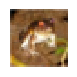

time: 535 ms (started: 2022-09-17 18:00:07 -07:00)


In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(0.75, 0.75))
plt.axis("off")
plt.imshow(
    data[0].reshape(3, 32, 32).transpose(1, 2, 0),
    interpolation="nearest",
    vmin=0,
    vmax=255,
)

# The reshaping and transposing above is the equivalent of:
#     im_r = data[0, :1024].reshape(32, 32)
#     im_g = data[0, 1024:2048].reshape(32, 32)
#     im_b = data[0, 2048:].reshape(32, 32)
#     img = np.dstack((im_r, im_g, im_b))

Squint hard enough and you'll see that's a frog and hence `labels[0] == 6`.

## Pipeline

In [4]:
target = pd.DataFrame(dict(labels=labels, description=label_names[labels]))
target

,labels,description
0,6,frog
1,9,truck
2,9,truck
3,4,deer
4,1,automobile
...,...,...
59995,8,ship
59996,3,cat
59997,5,dog
59998,1,automobile


time: 16.4 ms (started: 2022-09-17 18:00:09 -07:00)


In [5]:
from drnb.io.pipeline import create_default_pipeline

data_result = create_default_pipeline(check_for_duplicates=True).run(
    "cifar10",
    data=data,
    target=target,
    tags=["image"],
    url="https://www.cs.toronto.edu/~kriz/cifar.html",
    verbose=True,
)

[18:00:14] INFO     Requesting one extra neighbor to account for self-neighbor                      ]8;id=243152;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=125635;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#392\392]8;;\

           INFO     Initial data shape: (60000, 3072)                                                ]8;id=287397;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=608055;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#80\80]8;;\

           INFO     Keeping all columns                                                            ]8;id=644920;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=63031;file:///home/james/dev/drnb/src/drnb/preprocess.py#62\62]8;;\

           INFO     Data shape after filtering columns: (60000, 3072)                               ]8;id=554415;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=273421;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#151\151]8;;\

           INFO     Removing rows with NAs                                                          ]8;id=74511;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=257955;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#135\135]8;;\

[18:00:15] INFO     Data shape after filtering NAs: (60000, 3072)                                   ]8;id=752320;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=32829;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#146\146]8;;\

[18:00:18] INFO     Checked for duplicates: found 0                                                 ]8;id=880731;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=759029;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#158\158]8;;\

           INFO     No scaling                                                                     ]8;id=693317;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=853306;file:///home/james/dev/drnb/src/drnb/preprocess.py#25\25]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}                    ]8;id=533865;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=118400;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#163\163]8;;\

           INFO     Writing data for cifar10                                                        ]8;id=634993;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=113172;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#225\225]8;;\

[18:01:27] INFO     Processing target with initial shape (60000, 2)                                 ]8;id=473930;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=822116;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#196\196]8;;\

           INFO     Keeping all columns                                                            ]8;id=109582;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=763050;file:///home/james/dev/drnb/src/drnb/preprocess.py#62\62]8;;\

           INFO     Writing target for cifar10                                                      ]8;id=343627;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=455783;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#225\225]8;;\

           INFO     Calculating nearest neighbors                                                   ]8;id=660862;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=927441;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#240\240]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and params: {}           ]8;id=217901;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=254684;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#71\71]8;;\

           INFO     Loading faiss with AVX2 support.                                                   ]8;id=506559;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=839685;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=124548;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=809496;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=653663;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=608753;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

           INFO     Successfully loaded faiss.                                                         ]8;id=272310;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=483060;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

[18:01:36] INFO     Writing csv format to nn/cifar10.16.euclidean.exact.faiss.idx.csv               ]8;id=813540;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=725124;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[18:01:37] INFO     Writing numpy format to nn/cifar10.16.euclidean.exact.faiss.idx.npy             ]8;id=245057;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=608116;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

[18:01:39] INFO     Writing csv format to nn/cifar10.16.euclidean.exact.faiss.dist.csv              ]8;id=846008;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=780288;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[18:01:40] INFO     Writing numpy format to nn/cifar10.16.euclidean.exact.faiss.dist.npy            ]8;id=67955;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=553188;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

[18:01:41] INFO     Writing csv format to nn/cifar10.51.euclidean.exact.faiss.idx.csv               ]8;id=461954;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=999652;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[18:01:44] INFO     Writing numpy format to nn/cifar10.51.euclidean.exact.faiss.idx.npy             ]8;id=660467;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=894452;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

[18:01:50] INFO     Writing csv format to nn/cifar10.51.euclidean.exact.faiss.dist.csv              ]8;id=21199;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=749533;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[18:01:53] INFO     Writing numpy format to nn/cifar10.51.euclidean.exact.faiss.dist.npy            ]8;id=375038;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=913472;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

[18:01:56] INFO     Writing csv format to nn/cifar10.151.euclidean.exact.faiss.idx.csv              ]8;id=379908;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=971962;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[18:02:03] INFO     Writing numpy format to nn/cifar10.151.euclidean.exact.faiss.idx.npy            ]8;id=919879;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=686788;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

           INFO     Writing csv format to nn/cifar10.151.euclidean.exact.faiss.dist.csv             ]8;id=354575;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=521509;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[18:02:13] INFO     Writing numpy format to nn/cifar10.151.euclidean.exact.faiss.dist.npy           ]8;id=515719;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=70125;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

           INFO     Calculating triplets                                                            ]8;id=137736;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=477764;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#276\276]8;;\

[18:02:17] INFO     Writing csv format to triplets/cifar10.5.1337.idx.csv                           ]8;id=150784;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=919311;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[18:02:18] INFO     Writing csv format to triplets/cifar10.5.1337.l2.csv                            ]8;id=500480;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=114488;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[18:02:19] INFO     Writing numpy format to triplets/cifar10.5.1337.idx.npy                         ]8;id=116097;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=839299;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

           INFO     Writing numpy format to triplets/cifar10.5.1337.l2.npy                          ]8;id=668931;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=798719;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

           INFO     Writing pipeline result for cifar10                                             ]8;id=16223;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=821026;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#128\128]8;;\

time: 2min 8s (started: 2022-09-17 18:00:11 -07:00)
